In [1]:
# Hacky way to import from parent directory
# https://www.reddit.com/r/learnpython/comments/x6nibz/comment/in7rxzu/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
import sys
sys.path.append('..')

In [3]:
from ebirdtools import EBirdTools
# San Jose
data_sj = EBirdTools.load_data('../data/ebd_2025-08-20-20-26-00_37.33_-121.86_30_50.csv').sample(frac=0.1)
# Everglades (Florida). This file is small so it's ok to load more.
data_eg = EBirdTools.load_data('../data/ebd_2025-08-20-20-31-45_25.75_-80.56_30_50.csv').sample(frac=0.5)
# Chicago
data_ch = EBirdTools.load_data('../data/ebd_2025-08-20-20-35-54_41.88_-87.63_30_50.csv').sample(frac=0.1)
# Los Angeles
data_la = EBirdTools.load_data('../data/ebd_2025-08-20-20-40-54_34.05_-118.24_30_50.csv').sample(frac=0.1)
# Seattle
data_se = EBirdTools.load_data('../data/ebd_2025-08-20-20-44-54_47.61_-122.33_30_50.csv').sample(frac=0.1)

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import plotly.express as px
import seaborn as sns

In [133]:
def label_clusters(df, plot_px=False, plot_sns=False):
    """
    Returns a copy of the input df with a new column
    specifying which cluster each row belongs to.
    """
    clustering = DBSCAN(eps=0.02, min_samples=50).fit(df[['lat', 'lng']])
    
    df_aug = df.copy()
    df_aug['cluster'] = pd.Series(clustering.labels_, index=df_aug.index)
    # DBSCAN uses labels of '-1' for points that are too noisy to cluster
    df_aug = df_aug[df_aug['cluster'] != -1]
    
    if plot_px:
        fig = px.scatter_mapbox(df_aug, lat='lat', lon='lng', color='cluster', hover_name='comName')
        fig.update_mapboxes(style='open-street-map')
        fig.show()
    if plot_sns:
        fig = sns.scatterplot(df_aug, x='lng', y='lat', hue='cluster')
        plt.show()
    return df_aug

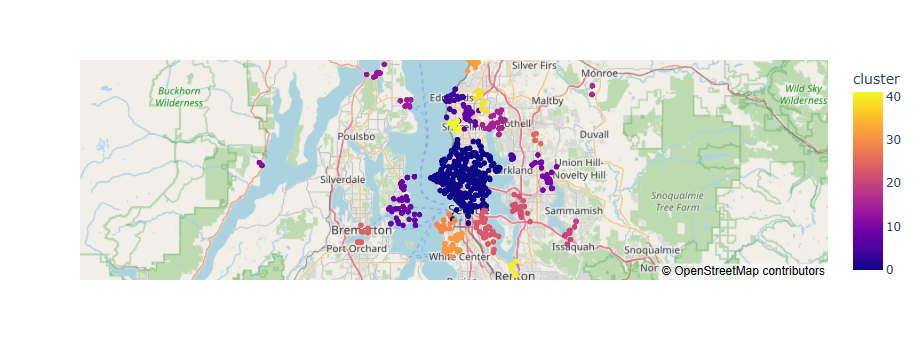

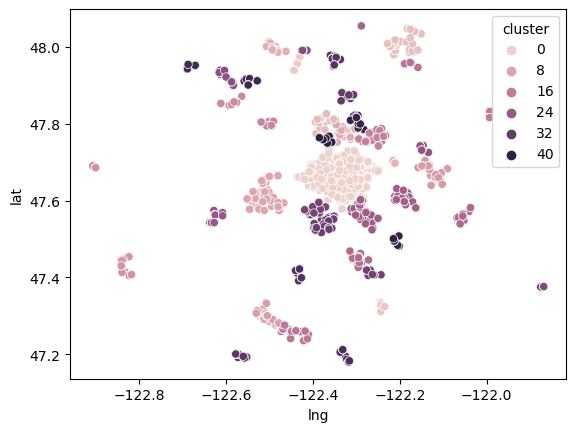

cluster
0     1652
3      448
8      362
9      300
23     269
6      250
4      240
11     233
26     185
10     153
31     130
15     127
17     122
29     116
7      109
22     102
24      99
20      90
16      87
5       85
19      83
34      77
2       75
38      73
39      70
35      66
33      65
13      61
21      61
30      60
25      57
1       57
28      57
18      56
27      54
37      54
12      53
32      52
40      52
36      50
14      50
41      49
Name: count, dtype: int64

In [135]:
label_clusters(data_se, plot_px=True, plot_sns=True)['cluster'].value_counts()

In [93]:
def species_per_cluster(df, by='comName'):
    """
    Takes a df and returns a dict:
        Key: Cluster number
        Val: set of names found in the cluster
    """
    species = {}
    for i in pd.unique(df['cluster']):
        names = set(df[df['cluster'] == i][by])
        species[i] = names
    return species

In [95]:
def get_similarity(df_a, df_b):
    """
    Gets cluster similarity by calculating the set
    similarity of the species names found in each cluster.
    """
    output = []
    sp_a = species_per_cluster(df_a)
    sp_b = species_per_cluster(df_b)
    for k_a, v_a in sp_a.items():
        for k_b, v_b in sp_b.items():
            iou = len(v_a.intersection(v_b)) / len(v_a.union(v_b))
            d = {'A': k_a, 'B': k_b, 'iou': iou}
            output.append(d)
    return pd.DataFrame(output)

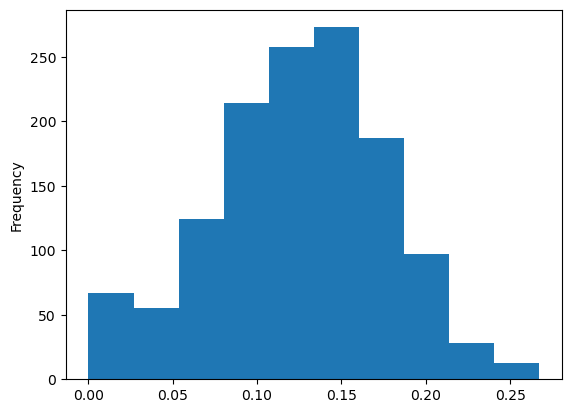

In [141]:
cluster_similarities = get_similarity(
    label_clusters(data_sj),
    label_clusters(data_ch)
)
_ = cluster_similarities['iou'].plot.hist()

In [119]:
def foo(name, df_src, df_tgt):
    if name not in df_src['comName'].values:
        raise KeyError('Unable to find species in the source location.')
    print('Is bird already found at the target location?', name in df_tgt['comName'].values)
    
    df_src = label_clusters(df_src)
    df_tgt = label_clusters(df_tgt)
    # find which source clusters the named species occurs in
    src_clusters = np.unique(df_src[df_src['comName'] == name]['cluster'])
    # drop the clusters that the named species doesn't occur in
    df_src = df_src[df_src['cluster'].isin(src_clusters)]
    # compare species sets
    sims = get_similarity(df_src, df_tgt)
    
    s_mean = sims['iou'].mean()
    s_std = sims['iou'].std()
    s_max = sims['iou'].max()
    z = (s_max - s_mean) / s_std
    a = sims[sims['iou'] == s_max]['A'].item()
    b = sims[sims['iou'] == s_max]['B'].item()

    sight_a = len(df_src[df_src['cluster'] == a])
    sight_b = len(df_tgt[df_tgt['cluster'] == b])
    spec_a = len(species_per_cluster(df_src)[a])
    spec_b = len(species_per_cluster(df_tgt)[b])
    
    print('Sub-cluster compatability:', round(s_mean, 2))
    print('Highest similarity:', round(s_max, 2), f'(z {round(z, 2)})')
    print('Source cluster:', a, f'(total {sight_a} sightings across {spec_a} species)')
    print('Target cluster:', b, f'(total {sight_b} sightings across {spec_b} species)')
    
    return sims

In [121]:
sims = foo("Western Bluebird", data_la, data_sj)

Is bird already found at the target location? True
Sub-cluster compatability: 0.22
Highest similarity: 0.57 (z 3.52)
Source cluster: 1 (total 2015 sightings across 107 species)
Target cluster: 8 (total 4883 sightings across 114 species)


In [122]:
sims = foo("Common Murre", data_sj, data_eg)

Is bird already found at the target location? False
Sub-cluster compatability: 0.04
Highest similarity: 0.17 (z 4.03)
Source cluster: 0 (total 5491 sightings across 112 species)
Target cluster: 16 (total 355 sightings across 61 species)


In [139]:
sims = foo("Canada Goose", data_se, data_ch)

Is bird already found at the target location? True
Sub-cluster compatability: 0.18
Highest similarity: 0.32 (z 2.77)
Source cluster: 10 (total 153 sightings across 41 species)
Target cluster: 12 (total 231 sightings across 53 species)
